In [22]:
%matplotlib inline

import load_local_neo_odml_elephant
import os
import imageio

import numpy as np
from autograd import grad, jacobian
import numdifftools as nd

import random
import math
import time
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy import optimize
from scipy.fft import rfft, rfftfreq, ifft
from scipy.stats import circvar
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import gridspec, ticker, colors
from matplotlib.pyplot import rcParams
from mpl_toolkits import mplot3d
import matplotlib.patches as patches

import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

from reachgraspio import reachgraspio
import odml.tools
import neo_utils
import odml_utils
import quantities as pq

from elephant.signal_processing import butter
from neo import Block, Segment

rcParams.update({'font.size': 13})
rcParams['figure.autolayout'] = True
rcParams['legend.fontsize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['axes.titlepad'] = 10
rcParams['axes.labelpad'] = 20
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['mathtext.fontset'] = 'cm' 
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana'] 
rcParams['animation.ffmpeg_path'] = r'/Users/administrator/Desktop/ffmpeg'

### Functions

In [23]:
def get_monkey_datafile(monkey):
    if monkey == "Lilou":
        return "l101210-001"  # ns2 and ns5 present
    elif monkey == "Nikos2":
        return "i140703-001"  # ns2 and ns6 present
    else:
        return ""

def autocorr(x,lags): 
    """
    Autocorrelation function for data and network response 
    """
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)
    
def nonlinearity(x, theta=0, phi_max=1):
    """
    Network nonlinearity (positive sigmoid)
    """
    return phi_max / (1 + np.exp(-(x-theta)))

def get_noise(N, n_trials, tau_wn, amp_wn, mean_wn):
    """
    Define Ornstein-Uhlenbeck noise input 
    """
    noises = []
    for trial in range(n_trials):  
        noise = np.zeros((N, iterations))
        for i in range(iterations-1):
            noise[:, i+1] = noise[:, i] + ((mean_wn - noise[:, i]) / tau_wn) + amp_wn * np.sqrt(2*dt/tau) * np.random.randn(N)
        noises.append(noise)
    return noises 

def get_timepoints(len_train, n_trials, n_repeats):
    """
    Define training and testing epochs
    """
    
    timepoints = np.arange(0, (len_train + n_trials) * (n_trials * n_repeats))
    timepoints = np.reshape(timepoints, (-1, len_train + n_trials))

    trains = []
    tests = []
    for trial in range(n_trials):
        train_reps = []
        test_reps = []
        for repeat in range(n_repeats):
            train_reps.append(timepoints[trial + n_trials*repeat, :len_train])
            test_reps.append(timepoints[trial + n_trials*repeat, -n_trials:])
        trains.append(np.vstack(train_reps))
        tests.append(np.vstack(test_reps))

    a, b = timepoints.shape
    n_tot = a*b
    
    return timepoints, trains, tests, n_tot

def tau_to_ms(tau):
    """
    Conversion factor from network timescale to ms
    """
    return tau * ((rescale_ms[-1].magnitude / max_length))

def ms_to_tau(ms):
    """
    Conversion factor from ms to network timescale
    """
    return ms /  ((rescale_ms[-1].magnitude / max_length))

def eigval_to_hz(eigval):
    """
    Conversion factor from eigenvalues of Jacobian to Hz
    """
    return eigval / ((rescale_ms[-1].magnitude / max_length) / 1000) / (np.pi * 2) 

def hz_to_eigval(hz):
    """
    Conversion factor from Hz to eigenvalues of Jacobian
    """
    return hz * ((rescale_ms[-1].magnitude / max_length) / 1000) * (np.pi * 2) 


# Functions for weight decay analysis 

def get_circular_indices(centre, radius):
    """
    Get indices of units a specified radius away from specified centre on electrode grid 
    """
    y, x = np.ogrid[:10, :10]
    dist_from_centre = np.sqrt((x - centre[1])**2 + (y-centre[0])**2)
    indices = dist_from_centre == radius
    values = reshape[indices]
    return values

def weights_vs_distance(J, distances):
    """
    Define mean weight between units separated by specific distance
    """
    dist_means = []
    dist_stds = []
    for dist in distances:
        dists_store = []
        for row in range(10):
            for col in range(10):
                values = get_circular_indices(centre=[row, col], radius=dist)
                for val in values:
                    if reshape[row][col] != -2 and val != -2:
                        dists_store.append(J[reshape[row][col], val])     
        dist_means.append(np.mean(dists_store))
        dist_stds.append(np.std(dists_store))
    return dist_means, dist_stds

def weights_vs_distance_pos_neg(J, distances):
    """
    Define mean weight between units separated by specific distance, separated into positive and negative weights
    """
    pos_means = []
    pos_stds = []
    neg_means = []
    neg_stds = []
    for dist in distances:
        pos_store = []
        neg_store = []
        for row in range(10):
            for col in range(10):
                values = get_circular_indices(centre=[row, col], radius=dist)
                for val in values:
                    if reshape[row][col] != -2 and val != -2:
                        if J[reshape[row][col], val] > 0:
                            pos_store.append(J[reshape[row][col], val]) 
                        if J[reshape[row][col], val] < 0:
                            neg_store.append(J[reshape[row][col], val]) 
        pos_means.append(np.mean(pos_store))
        pos_stds.append(np.std(pos_store))
        neg_means.append(np.mean(neg_store))
        neg_stds.append(np.std(neg_store))
    return pos_means, pos_stds, neg_means, neg_stds

    
def training(D, dt_weight_update, n_train, tau_trial, tau_baseline, amp_trial, amp_baseline, taus_baseline, amps_baseline):
    """
    Train network with given input noise parameters; return initial and trained connectivity matrix 
    """
    n_tot = n_train + 1
    
    noise_trial = get_noise(N, 1, tau_trial, amp_trial, 0)
    noise_baseline_graded = get_noise_amp_graded(N, 1, tau_baseline, amps_baseline, 0) 

    P = np.eye(n_targets) / alpha 
    J0 = np.random.randn(N, N) * g / np.sqrt(N) 
    J = J0.copy()

    for run in range(n_tot):
        xs = np.zeros((N, iterations))  
        zs = np.zeros((N, iterations)) 
        if run>0:
            xs[:, 0] = last_run

        for t in range(D, iterations-1):
            xs[:, t+1] = xs[:, t] + (-xs[:, t] + J.dot(nonlinearity(xs[:, t-D])) + noise_trial[0][:, t] + noise_baseline_graded[0][:, t]) * dt / tau
            r = nonlinearity(xs[:, t+1]) 
            r = r[:, None]    
            zs[:, t+1] = J.dot(np.squeeze(r))
            
            if run < n_train and t % dt_weight_update == 0:
                errs = zs[:n_targets, t+1] - targets_duplicated[0][:, t+1]
                k = P.dot(r[:n_targets])
                rPr = r[:n_targets].T.dot(k)
                c = 1.0 / (1.0 + rPr)
                P = P - c * (k.dot(k.T))
                delta_w = - (c * np.outer(errs, k))
#                 J[:n_targets, :n_targets] += delta_w
                
                for i in range(N):
                    if np.mean(J[:, i] > 0):
                        is_true = [J[:, i] + delta_w[:, i] > 0]
                        J[:, i][is_true] += delta_w[:, i][is_true]

                    if np.mean(J[:, i] <= 0):
                        is_true = [J[:, i] + delta_w[:, i] <= 0]
                        J[:, i][is_true] += delta_w[:, i][is_true]
                
                J[np.isclose(J, 0.0, atol=1e-04)] = 0.0

        last_run = xs[:, -1]
        
    return J0, J


# Functions for phase wave classification

def circular_arrangements(phase_directionality, array_dim):
    
    s_par=np.zeros((array_dim, array_dim))
    s_orth=np.zeros((array_dim, array_dim))
    for x in range(array_dim):
        for y in range(array_dim):
            l_xy = (x - 4.5) + 1j * (y - 4.5)
            l_xy_nor = l_xy/np.abs(l_xy)
            l_xy_nor_orth = (l_xy_nor) * np.exp(1j*0.5*np.pi)
            s_par[x,y] = complex_dot(l_xy_nor, phase_directionality[x,y])
            s_orth[x,y] = complex_dot(l_xy_nor_orth, phase_directionality[x,y])
    R_par = np.mean(np.abs(s_par))
    R_orth = np.mean(np.abs(s_orth))
    return R_par, R_orth


def gradient_continuity_at_timepoint(phase_directionality, array_dim):

    s = np.zeros((array_dim, array_dim)) 
    phase_zone = np.linspace(- np.pi + (0.125*np.pi), np.pi + (0.125*np.pi), 9)
    divider = 2 * np.pi / 8.0
    for x in range(array_dim):
        for y in range(array_dim):
            zone_judge = np.ceil((np.angle(phase_directionality)[x,y] - 0.125*np.pi) / divider) 
            i, j = phase_zone_pick[str(int(zone_judge))]
            if ((0 <= x + i <= array_dim - 1) & (0 <= y + j <= array_dim - 1)):
                s[x,y] = complex_dot(phase_directionality[x, y], phase_directionality[x+i, y+j])
    C = np.mean(s)
    return C

def gradient_continuity_alternative(phase_directionality, array_dim):
    
    sections = np.linspace(-np.pi, np.pi, 8) + (0.125*np.pi)
    quadrants = [[-1, -1], [0, -1], [1, -1], [1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0]]
    
    s = np.zeros((array_dim, array_dim)) 

    for x in range(array_dim):
        for y in range(array_dim):
            angle = np.angle(phase_directionality[x, y])
            for ind in range(7):
                if (sections[ind] < angle <= sections[ind+1]):
                    i, j = quadrants[ind]
                if (-np.pi < angle <= sections[0]):
                    i, j = quadrants[-1]
            if ((0 <= x + i <= array_dim - 1) & (0 <= y + j <= array_dim - 1)):
                s[x,y] = complex_dot(phase_directionality[x, y], phase_directionality[x+i, y+j])
    C = np.mean(s)
    return C

def gradient_coherence_at_timepoint(phase_directionality, array_dim):

    gradient_coherence=np.zeros((array_dim, array_dim), dtype=complex)
    
    for x in range(array_dim):
        for y in range(array_dim):
            gradient_coherence_xy = []
            for row in range(-2, 3):
                for col in range(-2, 3):
                    if ((0 <= x + row <= array_dim - 1) & (0 <= y + col <= array_dim - 1)):
                        x_coordinate = x + row
                        y_coordinate = y + col
                        gradient_coherence_xy.append(phase_directionality[x_coordinate, y_coordinate])
            gradient_coherence[x,y] = np.mean(gradient_coherence_xy, axis=0)

    return gradient_coherence

def phase_gradient_at_timepoint(phases, array_dim, N):
        
    phase_gradient = np.zeros((array_dim, array_dim), dtype=complex)
    phase = phases[:N].reshape(array_dim, array_dim)

    for x in range(array_dim):
        for y in range(array_dim):
            phase_gradient_xy = []
            for step in (-2, -1, 1, 2):
                if (0 <= x + step <= array_dim - 1):
                    if step > 0: alpha = 0
                    else: alpha = np.pi
                    x_coordinate = x + step
                    a = phase[x_coordinate, y]
                    b = phase[x, y]
                    if np.sign(a) == np.sign(b):
                        phase_difference = a - b
                    elif np.sign(a) > np.sign(b):
                        phase_difference = a - (np.pi + (np.pi - np.abs(b)))
                        if phase_difference < -np.pi: phase_difference = a - b
                    elif np.sign(a) < np.sign(b):
                        phase_difference = a - (- np.pi - (np.pi - np.abs(b)))
                        if phase_difference > np.pi: phase_difference = a - b
                    
                    phase_gradient_xy.append(phase_difference * np.exp(1j*alpha) / np.abs(step))

                if (0 <= y + step <= array_dim - 1):
                    if step > 0: alpha = 1.5* np.pi
                    else: alpha = 0.5 * np.pi
                    y_coordinate = y + step                     
                    a = phase[x, y_coordinate]
                    b = phase[x, y]
                    if np.sign(a) == np.sign(b):
                        phase_difference = a - b
                    elif np.sign(a) > np.sign(b):
                        phase_difference = a - (np.pi + (np.pi - np.abs(b)))
                        if phase_difference < -np.pi: phase_difference = a - b
                    elif np.sign(a) < np.sign(b):
                        phase_difference = a - (- np.pi - (np.pi - np.abs(b)))
                        if phase_difference > np.pi: phase_difference = a - b
                    phase_gradient_xy.append(phase_difference * np.exp(1j*alpha) / np.abs(step))
            phase_gradient[x,y] = np.mean(phase_gradient_xy, axis=0)
                
    return phase_gradient

def phase_gradient_at_timepoint_data(phases, array_dim, N):
        
    phase_gradient = np.zeros((array_dim, array_dim), dtype=complex)
    phase = np.reshape(phases[reshape_unravelled], (array_dim, array_dim))
#     lfp_reshape_masked = np.ma.masked_where(reshape==-2, lfp_reshape)

    for x in range(array_dim):
        for y in range(array_dim):
            phase_gradient_xy = []
            for step in (-2, -1, 1, 2):
                if(0 <= x + step <= array_dim - 1):
                    if step > 0: alpha = 0
                    else: alpha = np.pi
                    x_coordinate = x + step
                    a = phase[x_coordinate, y]
                    b = phase[x, y]
                    if np.sign(a) > np.sign(b):
                        phase_difference = a - (np.pi + (np.pi - np.abs(b)))
                        if phase_difference < -np.pi: phase_difference = a - b
                    if np.sign(a) < np.sign(b):
                        phase_difference = a - (- np.pi - (np.pi - np.abs(b)))
                        if phase_difference > np.pi: phase_difference = a - b
                    elif np.sign(a) == np.sign(b):
                        phase_difference = a - b
                    phase_gradient_xy.append(phase_difference * np.exp(1j*alpha) / np.abs(step))

                if (0 <= y + step <= array_dim - 1):
                    if step > 0: alpha = 1.5* np.pi
                    else: alpha = 0.5 * np.pi
                    y_coordinate = y + step                     
                    a = phase[x, y_coordinate]
                    b = phase[x, y]
                    if np.sign(a) > np.sign(b):
                        phase_difference = a - (np.pi + (np.pi - np.abs(b)))
                        if phase_difference < -np.pi: phase_difference = a - b
                    if np.sign(a) < np.sign(b):
                        phase_difference = a - (- np.pi - (np.pi - np.abs(b)))
                        if phase_difference > np.pi: phase_difference = a - b
                    elif np.sign(a) == np.sign(b):
                        phase_difference = a - b
                    phase_gradient_xy.append(phase_difference * np.exp(1j*alpha) / np.abs(step))
            phase_gradient[x,y] = np.mean(phase_gradient_xy, axis=0)
                
    return phase_gradient

phase_zone_pick={"-4":[0,-1],
                  "4":[0,-1], 
                  "-3":[-1,-1], 
                  "-2":[-1,0], 
                  "-1":[-1,1], 
                  "0":[0,1],
                  "1":[1,1], 
                  "2":[1,0],
                  "3":[1,-1]}

def complex_dot(a, b):
    return(a.real * b.real + a.imag * b.imag)
    
    
# General parameters

amplitude_unit = pq.microvolt
time_unit = pq.ms
Writer = animation.writers['ffmpeg']
writer = Writer(fps=50, bitrate=1800)

main_color = 'darkcyan'
main_color_dark = 'darkslategrey'
positive_color = 'darkgreen'
negative_color = 'darkred'

folder = 'duplicates_single'

### Load session and split into trials

In [24]:
# Specify directory where the data is stored
datasetdir = "/Users/administrator/multielectrode_grasp/datasets/"

# Specify which monkey to analyse
monkey = 'Lilou'

nsx_none = {'Lilou': None, 'Nikos2': None}
nsx_lfp = {'Lilou': 2, 'Nikos2': 2}
nsx_raw = {'Lilou': 5, 'Nikos2': 6}

datafile = get_monkey_datafile(monkey)

# Open the session for reading
session = reachgraspio.ReachGraspIO(filename=os.path.join(datasetdir, datafile), odml_directory=datasetdir)

# Read the first 50s of data from chosen number of electrodes
chosen_els = range(100)
chosen_units = 1
bl_raw = session.read_block(
    nsx_to_load=nsx_raw[monkey],
    n_starts=None,
    n_stops=50 * pq.s,
    channels=chosen_els,
    units=chosen_units,
    load_waveforms=False,
    load_events=True,
    scaling='voltage',
    lazy=False,
    cascade=True,
    correct_filter_shifts=True)

# Access the single segment of the data block, containing all trials 
assert len(bl_raw.segments) == 1
seg_raw = bl_raw.segments[0]  # there is only 1 segment 


warning[None:17:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag (line 17)
warning[None:17:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML> (line 17)


In [25]:
# Get start and stop events of trials with correct performance
start_events = neo_utils.get_events(
    seg_raw,
    properties={
        'name': 'TrialEvents',
        'trial_event_labels': 'CUE-OFF',
        'performance_in_trial': 255})
stop_events = neo_utils.get_events(
    seg_raw,
    properties={
        'name': 'TrialEvents',
        'trial_event_labels': 'GO-ON',
        'performance_in_trial': 255})

assert len(start_events) == 1
assert len(stop_events) == 1

# Create epochs around start and stop events 
epoch = neo_utils.add_epoch(
    seg_raw,
    start_events[0],
    stop_events[0],
    pre = -100 * pq.ms,
    post = -100 * pq.ms,
    trial_status='complete_trials',
    trial_type=start_events[0].annotations['belongs_to_trialtype'],
    trial_performance=start_events[0].annotations['performance_in_trial'])

raw_block = Block(name='raw_analysis_epoch')
raw_block.segments = neo_utils.cut_segment_by_epoch(seg_raw, epoch, reset_time=True)  # each segment = 1 trial


### Create targets from filtered LFP signals

96
96
96
96
96


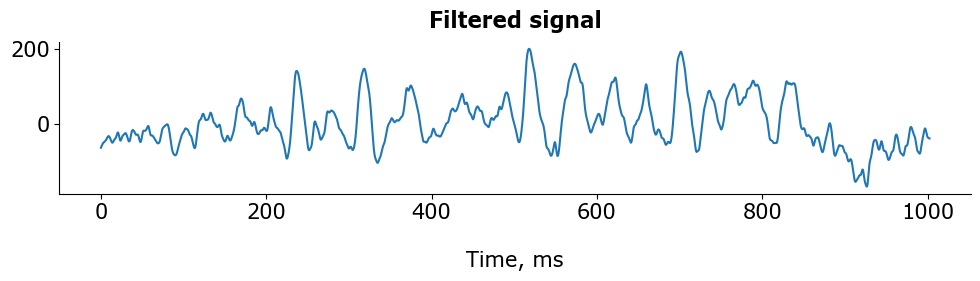

In [26]:
# Choose trials

trial_ids = [2, 3, 6, 7, 8]
n_signals = len(raw_block.segments[0].analogsignals)
filtered_signals = []

for trial in trial_ids:
    filtered_anasig = []
    print(len(raw_block.segments[trial].analogsignals))
    for anasig in raw_block.segments[trial].analogsignals:
        f_anasig = butter(
                anasig,
                highpass_freq=None,
                lowpass_freq=250 * pq.Hz,
                order=4)
        f_anasig.name = 'offline_lfp_%s' % anasig.name 
        filtered_anasig.append(f_anasig)

    # Attach all offline filtered LFPs to the raw_block segment of each trial 
    raw_block.segments[trial].analogsignals.extend(filtered_anasig)

    # Separate raw and filtered signals 
    raw_sigs = raw_block.segments[trial].analogsignals[0:n_signals]
    filtered_sigs = raw_block.segments[trial].analogsignals[n_signals:]
    filtered_signals.append(filtered_sigs)
    
# Find signal with shortest length
shortest = np.argmin([len(x[0]) for x in filtered_signals])
rescale_ms = filtered_signals[shortest][0].times.rescale(pq.ms)
max_length = min([len(x[0]) for x in filtered_signals])
rescale_ms_ds = rescale_ms[::10]
max_time_ds = len(rescale_ms_ds)
    
# Plot to check 
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
ax.plot(rescale_ms, filtered_signals[0][0].squeeze().rescale(pq.microvolt)[:max_length])
ax.set_xlabel('Time, ms')
ax.set_title('Filtered signal', fontweight='bold')
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.show()


In [13]:
# Create targets from filtered signals
targets = []
targets_ds = []

for filtered_sig in filtered_signals:
    targets_unselected = []
    for sig in filtered_sig:
            targets_unselected.append(sig.squeeze().rescale(amplitude_unit))

    remove_idxs = [42] 
    for idx, timeseries in enumerate(targets_unselected):
        if np.max(np.abs(timeseries)) > 250:
            remove_idxs.append(idx)

    targets_unselected = [x.magnitude for x in targets_unselected]
    targets_trial = np.vstack(targets_unselected)

    for bad in remove_idxs:
        targets_trial[bad] = 0.0

    targets_trial = targets_trial/targets_trial.max()
    targets_trial_ds = np.squeeze([x[::10] for x in targets_trial])

    targets.append(targets_trial)
    targets_ds.append(targets_trial_ds)

targets_duplicated = []
for x in targets:
    targets_duplicated.append(np.vstack((x, x)))
    

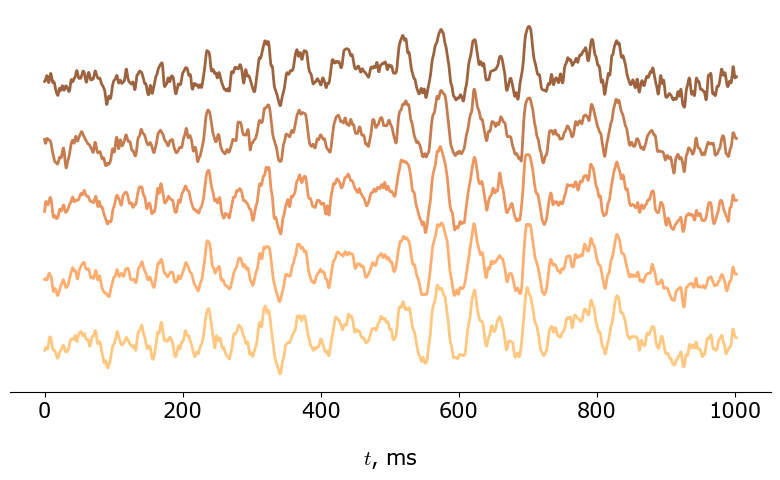

In [15]:
# Plot remaining targets

rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

n_to_show = 5

for i in range(n_to_show):
    colors = pl.cm.copper_r(np.linspace(0, 0.5, n_to_show))
    ax.plot(rescale_ms, targets[0][i+10][:max_length] + i, color=colors[i], lw=2)  
                
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'$t$, ms')
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
fig.tight_layout()
plt.show()


### Gif of targets

In [16]:
signal_to_plot = targets[0]

frames = []
scale_limit = 0.8

fig = plt.figure()
plt.axis('off')
for i in np.arange(0, max_length, 50):
    lfp_at_timepoint = signal_to_plot[:, i]
    lfp_reshape = np.reshape(lfp_at_timepoint[reshape_unravelled], (10, 10))
    lfp_reshape_masked = np.ma.masked_where(reshape==-2, lfp_reshape)
    image = plt.imshow(lfp_reshape_masked, cmap='gist_heat', animated=True, vmin=-scale_limit, vmax=scale_limit)
    frames.append([image])
plt.close()

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True, repeat_delay=1000) 

HTML(ani.to_html5_video())

KeyboardInterrupt: 

In [ ]:
ani.save('%s/targets0_gif.mp4' % folder, writer=writer) 

### Classification measures at each timepoint 

In [17]:
# Define which trial to analyse 

trial_num = 0
array_dim = 10
signal_to_analyse = targets[trial_num]
hilbert_transform = signal.hilbert(signal_to_analyse, axis=1)
phases = np.angle(hilbert_transform)
amplitudes = np.abs(hilbert_transform)


In [18]:
# Collect phase maps and measures at each timepoint 

sigma_p = [] # circular variance of phase
sigma_g = [] # circular variance of phase directionality
mu_c = []    # local gradient coherence
C = []       # gradient continuity 
R_par = []   # radial-parallel alignment 
R_orth = []  # radial-orthogonal alignment 

phase_gradients = []
phase_speeds = []
average_phase_speeds = []
phase_directionalities = []
gradient_coherences = []

start = 15000
length_to_analyse = 10000
step = 10

for timepoint in np.arange(start, start + length_to_analyse, 10):

    phase = phases[:, timepoint]
    amplitude = amplitudes[:, timepoint]
    phase_gradient = phase_gradient_at_timepoint_data(phase, array_dim, len(phase))
    
    freq_beta = 21.5
    phase_speed = (2 * np.pi * freq_beta) / (np.abs(phase_gradient))
    average_phase_speed = phase_speed.mean()
    phase_directionality = phase_gradient / np.abs(phase_gradient)
    gradient_coherence = gradient_coherence_at_timepoint(phase_directionality, array_dim)
    
    circular_variance = 1 - np.abs(np.mean([np.exp(1j * p) for p in phase])) # [0, 1] [synchronous, distributed]
#     circular_variance = circvar(phase, 0, 1)
    
    circular_variance_phase_dir = np.abs(np.mean([np.exp(1j * p) for p in np.angle(phase_directionality)])) # [0, 1] [planar, random]
#     circular_variance_phase_dir = 1 - circvar(np.angle(phase_directionality), 0, 1)
    
    local_gradient_coherence = np.abs(np.mean(gradient_coherence / np.abs(gradient_coherence))) # [0, 1] [locally random, locally planar]
    
    gradient_continuity = gradient_continuity_at_timepoint(phase_directionality, array_dim) # [-1, 1] [continuous parallel, continuous orthogonal]
#     gradient_continuity = gradient_continuity_alternative(phase_directionality, array_dim)
    
    radial_parallel, radial_orthogonal = circular_arrangements(phase_directionality, array_dim) # [0, 1] [random/planar, radial/circular]
        
    sigma_p.append(circular_variance)
    sigma_g.append(circular_variance_phase_dir)
    mu_c.append(local_gradient_coherence)
    C.append(gradient_continuity)
    R_par.append(radial_parallel)
    R_orth.append(radial_orthogonal)

    phase_gradients.append(phase_gradient)
    phase_speeds.append(phase_speed)
    average_phase_speeds.append(average_phase_speed)
    phase_directionalities.append(phase_directionality)
    gradient_coherences.append(gradient_coherence)
    

In [19]:
def wave_classification(sigma_p, sigma_g, mu_c, C, R_par, R_orth):
    
    syn = ((np.array(sigma_p) < 0.4) &
           (np.array(sigma_g) > 0.2))
    planar = (np.array(sigma_g) < 0.3)
    radial = (np.array(R_par) > 0.65)
    circular = ((np.array(sigma_p) > 0.7) & 
                (np.array(sigma_g) > 0.6) & 
                (np.array(C) > 0.85) & 
                (np.array(R_orth) > 0.65))
    rand = ((np.array(sigma_p) > 0.6) &
            (np.array(sigma_g) > 0.3) &
            (np.array(mu_c) < 0.5))   
    
    return syn, planar, radial, circular, rand

syn, planar, radial, circular, rand = wave_classification(sigma_p, sigma_g, mu_c, C, R_par, R_orth)

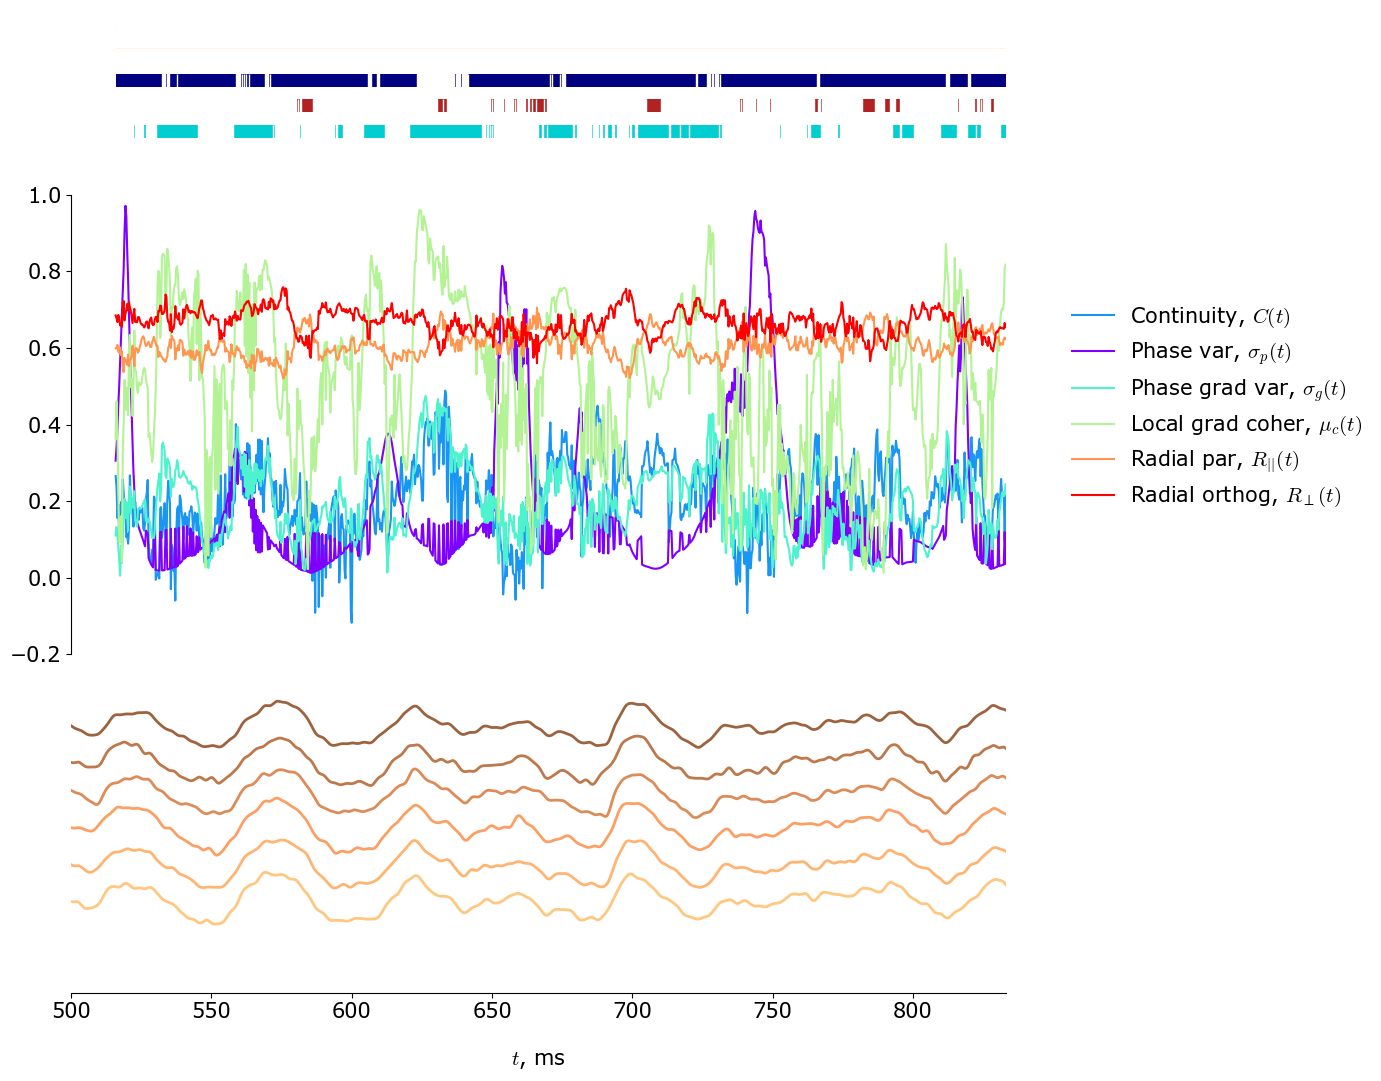

In [20]:
classifications = [syn, radial, planar, circular, rand]
classification_colors = ['darkturquoise', 'firebrick', 'navy', 'darkorange', 'yellowgreen', 'orchid']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 11), gridspec_kw={'height_ratios': [1, 3, 2]}, dpi=100)

height_bar = 0.1
positions_bar = np.arange(0, 1, 0.2)[::1]
length_plot = int(length_to_analyse/step)

for i in range(5):
    bar = patches.Rectangle((0, positions_bar[i]), length_plot, height_bar, facecolor=classification_colors[i])
    ax1.add_patch(bar)
    ax1.fill_between(np.arange(length_plot), positions_bar[i], positions_bar[i] + height_bar, where=classifications[i]==False, color='white', zorder=3)

colors = pl.cm.gist_earth(np.linspace(0, 1, 6))

ax2.plot(C, c=colors[1], label=r'Continuity, $C(t)$')
ax2.plot(sigma_p, c=colors[0], label=r'Phase var, $\sigma_p(t)$')
ax2.plot(sigma_g, c=colors[2], label=r'Phase grad var, $\sigma_g(t)$')
ax2.plot(mu_c, c=colors[3], label=r'Local grad coher, $\mu_c(t)$')
ax2.plot(R_par, c=colors[4], label=r'Radial par, $R_{||}(t)$')
ax2.plot(R_orth, c=colors[5], label=r'Radial orthog, $R_{\perp}(t)$')
ax2.legend(frameon=False, loc=0, bbox_to_anchor=[1.05, 0.8], fontsize=15)

n_to_show = 6
for i in range(n_to_show):
    colors = pl.cm.bone(np.linspace(0, 0.5, n_to_show))
    ax3.plot(rescale_ms[start:start+length_to_analyse], signal_to_analyse[i+10][start:start+length_to_analyse] + .8*i, color=colors[i], lw=2)  

ax3.set_xlim(rescale_ms[start], rescale_ms[start+length_to_analyse])

for ax in ax1, ax2:
    ax.set_xlim(-50, len(C))
    ax.set_ylim(-0.2, 1)
    
for ax in ax1, ax2, ax3:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)

sns.despine(ax=ax3, top=True, right=True, left=True, bottom=False)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=True)

ax3.set_ylim(-2, 5)
ax3.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax3.set_xlabel('$t$, ms', labelpad=20)

fig.tight_layout()
plt.savefig('%s/classification_measures.png'%folder, dpi=200)
plt.show()

In [105]:
# Gif of activations, phase maps and classifications 

rcParams['font.size'] = 11
rcParams['axes.titlepad'] = 12
titles = ['Synchr.', 'Radial', 'Planar', 'Circular', 'Random']
timepoints = np.arange(start, start + length_to_analyse, 10)
array_dim = 10

frames = []

for timeindex, timepoint in enumerate(timepoints):

    fig, axs = plt.subplots(2, 5, figsize=(15, 5), gridspec_kw={'height_ratios': [5, 1]}, dpi=200) 

    im1 = axs[0, 0].imshow(amplitudes[reshape_unravelled][:, timepoint].reshape(array_dim, array_dim), cmap='gist_heat', vmin=-1, vmax=1, origin='lower')
    cbar = fig.colorbar(im1, ax=axs[0, 0], ticks=[-1, 0, 1], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=0)
    cbar.ax.set_yticklabels([r'$-1$', r'$0$', r'$1$'], fontsize=15)
    axs[0, 0].set_title('Amplitude')

    im2 = axs[0, 1].imshow(phases[reshape_unravelled][:, timepoint].reshape(array_dim, array_dim), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi, origin='lower')
    cbar = fig.colorbar(im2, ax=axs[0, 1], ticks=[-np.pi, 0, np.pi], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=0)
    cbar.ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    axs[0, 1].set_title('Phase')
    
    left1 = -0.13
    left2 = -0.12
    right1 = 1.04
    right2 = 1.0

    quantity = phase_gradients[timeindex]
    X, Y = np.meshgrid(np.arange(0, array_dim), np.arange(0, array_dim))
    U = quantity.real
    V = quantity.imag
    M = quantity.imag
    im3 = axs[0, 2].imshow(np.zeros(array_dim*array_dim).reshape(array_dim, array_dim), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
    axs[0, 2].imshow(np.zeros(array_dim*array_dim).reshape(array_dim, array_dim), cmap='Greys', vmin=0, vmax=1)
    axs[0, 2].quiver(X, Y, U, V, M, units='x', cmap='twilight_shifted', width=0.08, scale=1.2, angles='xy')
    cbar = fig.colorbar(im3, ax=axs[0, 2], ticks=[-np.pi, 0, np.pi], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=0)
    cbar.ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    axs[0, 2].axis([left1*array_dim, right1*array_dim, left2*array_dim, right2*array_dim])
    axs[0, 2].set_title('Phase gradient')

    quantity = phase_directionalities[timeindex]
    X, Y = np.meshgrid(np.arange(0, array_dim), np.arange(0, array_dim))
    U = quantity.real
    V = quantity.imag
    M = quantity.imag
    im4 = axs[0, 3].imshow(np.zeros(array_dim*array_dim).reshape(array_dim, array_dim), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
    axs[0, 3].imshow(np.zeros(array_dim*array_dim).reshape(array_dim, array_dim), cmap='Greys', vmin=0, vmax=1)
    axs[0, 3].quiver(X, Y, U, V, M, units='x', cmap='twilight_shifted', width=0.08, scale=1.5, angles='xy')
    cbar = fig.colorbar(im4, ax=axs[0, 3], ticks=[-np.pi, 0, np.pi], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=0)
    cbar.ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    axs[0, 3].axis([left1*array_dim, right1*array_dim, left2*array_dim, right2*array_dim])
    axs[0, 3].set_title('Phase directionality')

    quantity = gradient_coherences[timeindex]
    X, Y = np.meshgrid(np.arange(0, array_dim), np.arange(0, array_dim))
    U = quantity.real
    V = quantity.imag
    M = quantity.imag
    im4 = axs[0, 4].imshow(np.zeros(array_dim*array_dim).reshape(array_dim, array_dim), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
    axs[0, 4].imshow(np.zeros(array_dim*array_dim).reshape(array_dim, array_dim), cmap='Greys', vmin=0, vmax=1)
    axs[0, 4].quiver(X, Y, U, V, M, units='x', cmap='twilight_shifted', width=0.08, scale=0.6, angles='xy')
    cbar = fig.colorbar(im4, ax=axs[0, 4], ticks=[-np.pi, 0, np.pi], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(size=0)
    cbar.ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
    axs[0, 4].axis([left1*array_dim, right1*array_dim, left2*array_dim, right2*array_dim])
    axs[0, 4].set_title('Gradient coherence')
    
    color_on = ['whitesmoke']*5
    
    for i in range(5):
        if ((classifications[i][timeindex] == 1) & (classifications[i-1][timeindex] != 1) & (classifications[i-2][timeindex] != 1)):
            color_on[i] = 'grey'
        square = patches.Rectangle((0.2, 1), 0.8, 0.6, edgecolor='k', facecolor=color_on[i])
        axs[1, i].add_patch(square)
        axs[1, i].set_xlim(0, 2)
        axs[1, i].set_ylim(0, 2)
        axs[1, i].text(1.2, 1.1, titles[i], fontsize=14)
    
    for i in range(2):
        for j in range(5):
            axs[i, j].get_xaxis().set_visible(False)
            axs[i, j].get_yaxis().set_visible(False)
            sns.despine(ax=axs[1, j], top=True, right=True, left=True, bottom=True)
        
    plt.savefig('%s/all_graphs/noise_%s.png' % (folder, timepoint), dpi=200)

    plt.close()



### Network architecture

In [31]:
# Training parameters 

N = len(targets_duplicated[0]) 
n_targets = len(targets_duplicated[0]) 

g = 1.5
tau = 100 
D = 60
dt_weight_update = 10
alpha = 1 

T = max_length
dt = 1 
iterations = int(T/dt)  
times = np.linspace(0, T, iterations)

n_train = 10
n_free = 1
n_tot = n_train + n_free 

# Define noise
tau_trial = ms_to_tau(5)
amp_trial = 0.00
tau_baseline = ms_to_tau(5)
amp_baseline = 0.00
amps_baseline = np.linspace(0.00, 0.04, N)
taus_baseline = np.linspace(ms_to_tau(5), ms_to_tau(30), N)

noise_trial = get_noise(N, 1, tau_trial, amp_trial, 0.0)
noise_baseline = get_noise(N, 1, tau_baseline, amp_baseline, 0.0)
noise_baseline_graded = get_noise(N, 1, taus_baseline, amps_baseline, 0) 

P = np.eye(n_targets) / alpha 
J0 = np.random.randn(N, N) * g / np.sqrt(N) 
J = J0.copy()

J_evolution = []
J_evolution.append(J0)
save_J_every = int(n_train/5)

zs_all = []
mses = []
deltas_all = np.zeros(n_targets)  
deltas_all = deltas_all[:, None]

start_time = time.time()

for run in range(n_tot):
    
    print(run)
    
    xs = np.zeros((N, iterations))  
    zs = np.zeros((N, iterations)) 
    deltas = np.zeros((n_targets, iterations)) 
    mse = []
    
    if run>0:
        xs[:, 0] = last_run
    
    for t in range(D, iterations-1):
#         xs[:, t+1] = xs[:, t] + (-xs[:, t] + J.dot(nonlinearity(xs[:, t-D])) + noise_baseline[0][:, t]) * dt / tau
        xs[:, t+1] = xs[:, t] + (-xs[:, t] + J.dot(nonlinearity(xs[:, t-D])) + noise_trial[0][:, t] + noise_baseline_graded[0][:, t]) * dt / tau
        r = nonlinearity(xs[:, t+1]) 
        r = r[:, None]    
        zs[:, t+1] = J.dot(np.squeeze(r))

        if run < n_train and t % dt_weight_update == 0:
            
            errs = zs[:n_targets, t+1] - targets_duplicated[0][:, t+1]
            mse.append(np.mean(errs**2))
            
            k = P.dot(r[:n_targets])
            rPr = r[:n_targets].T.dot(k)
            c = 1.0 / (1.0 + rPr)
            P = P - c * (k.dot(k.T))
            
            delta_w = - (c * np.outer(errs, k))
            deltas[:, t] = np.linalg.norm(delta_w, axis=0)
            
            # Impose E-I structure during training 
            for i in range(N):
                if np.mean(J[:, i] > 0):
                    is_true = [J[:, i] + delta_w[:, i] > 0]
                    J[:, i][is_true] += delta_w[:, i][is_true]
                    J[:, i][not(is_true)] = 0.0
                            
                if np.mean(J[:, i] <= 0):
                    is_true = [J[:, i] + delta_w[:, i] < 0]
                    J[:, i][is_true] += delta_w[:, i][is_true]
                    J[:, i][not(is_true)] = 0.0
                            
#             J[:n_targets, :n_targets] += delta_w
            J[np.isclose(J, 0.0, atol=1e-04)] = 0.0
            
    last_run = xs[:, -1]
    
    if run % save_J_every == 0:
        J_current = J.copy()
        J_evolution.append(J_current)
        
    mses.append(np.mean(mse))
    zs_all.append(zs)
    deltas_all = np.concatenate((deltas_all, deltas), axis=1)
    
print('Time elapsed: %.2f' % ((time.time() - start_time)/60) + ' min')

0


<ipython-input-31-3266b35d5da0>:83: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  J[:, i][is_true] += delta_w[:, i][is_true]
<ipython-input-31-3266b35d5da0>:88: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  J[:, i][is_true] += delta_w[:, i][is_true]


1
2
3
4
5
6
7
8
9
10


/opt/anaconda3/envs/multielectrode_grasp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/multielectrode_grasp/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Time elapsed: 7.19 min


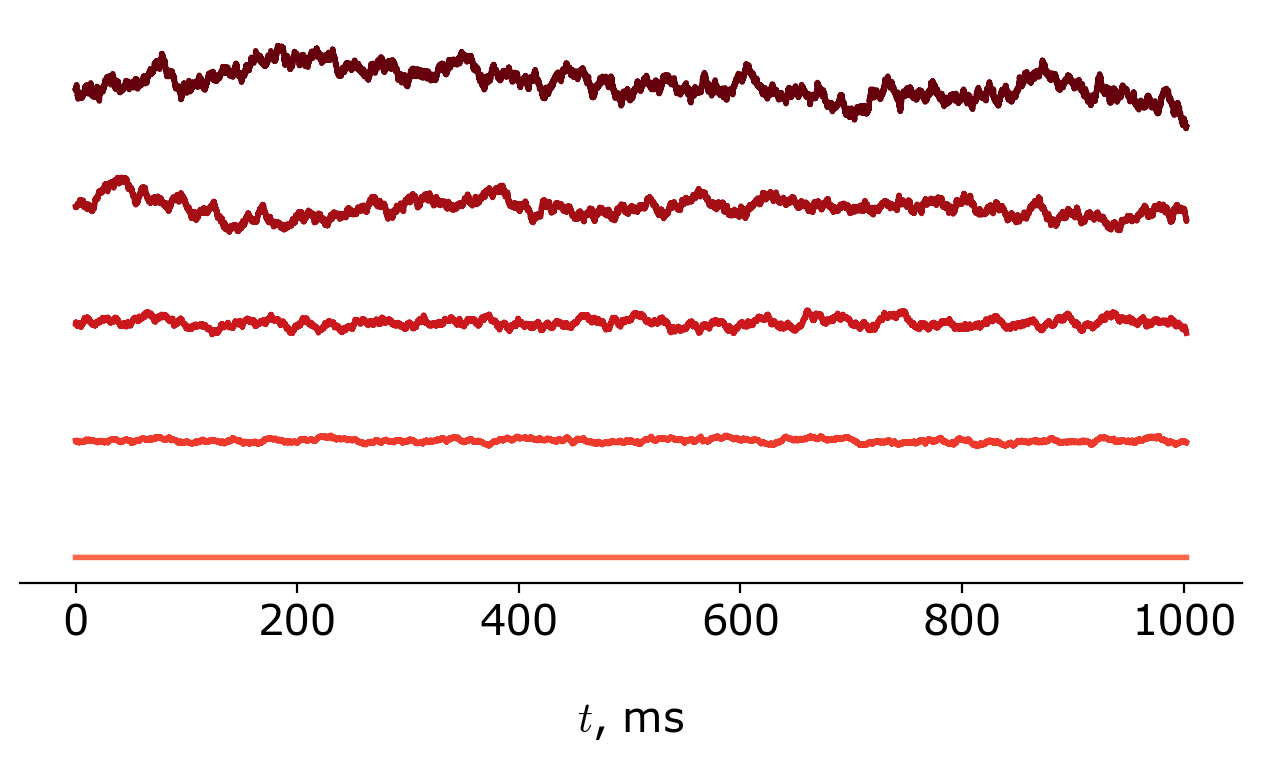

In [32]:
# Plot graded noise inputs

fig, ax = plt.subplots(figsize=(6.5, 4), dpi=100)
colors = pl.cm.Reds(np.linspace(0.5, 1, 5))

for ind, val in enumerate(np.linspace(0, N-1, 5, dtype='int')):
    ax.plot(rescale_ms, noise_baseline_graded[0][val, :] + ind, color=colors[ind], alpha=1, lw=2)
#     ax.plot(rescale_ms, noise_baseline[0][val, :] + ind, color=colors[ind], alpha=1, lw=2)

ax.set_xlabel('$t$, ms', labelpad=20)
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
fig.tight_layout()
plt.savefig('%s/noise_inputs.png'%folder, dpi=200)
plt.show()

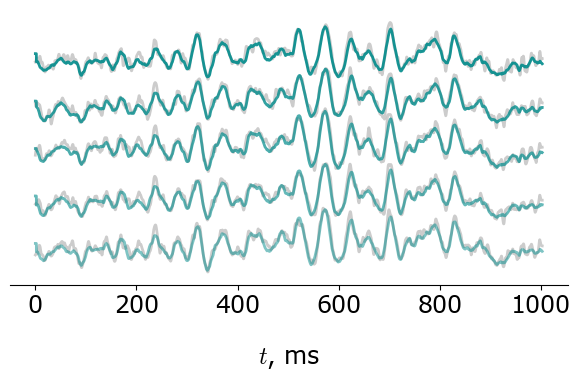

In [33]:
# Plot readout versus target for selection of neurons

rcParams['axes.labelsize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

for i in range(10, 15):
    label_target, label_output = None, None
    if i == 14:
        label_target, label_output = 'Target', 'Network output'
    ax.plot(rescale_ms, targets[0][i, :] + i , color='grey', alpha=0.4, linewidth=2, label=label_target)
    ax.plot(rescale_ms, zs_all[-1][i, :] + i , color='darkcyan', alpha=((i/10 - 1)+0.5), linewidth=2, label=label_output)

ax.set_xlabel('$t$, ms', labelpad=20)
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
fig.tight_layout()
plt.savefig('%s/sample_dynamics.png'%folder, dpi=200)
plt.show()


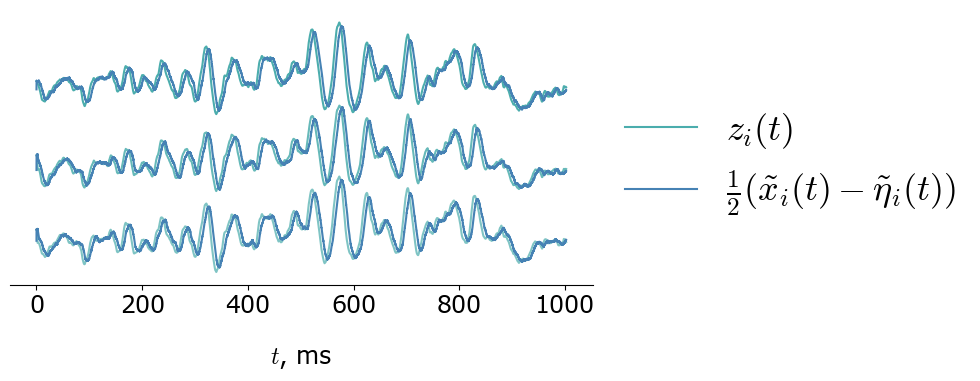

In [34]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

rcParams['axes.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

for i in range(10, 13):
    labels = [None]*6
    if i == 12:
        labels = [r'$z_i(t)$', r'$x^1_i(t)$',  r'$x^2_i(t)$', r'$\tilde{\eta}_i (t)$', 
                  r'$\tilde{x}_i (t)$', r'$\frac{1}{2} \left( \tilde{x}_i (t) - \tilde{\eta}_i (t) \right) $']
    
    ax.plot(rescale_ms, zs_all[-1][i, :] + i , color='darkcyan', alpha=((i/10 - 1)+0.5), label = labels[0])
#     ax.plot(rescale_ms, zs_all[-1][i+96, :] + i , color='darkcyan', alpha=((i/10 - 1)+0.5))
#     ax.plot(rescale_ms, xs[i, :] + i , color='maroon', alpha=((i/10 - 1)+0.5), label = labels[1])
#     ax.plot(rescale_ms, xs[i+96, :] + i , color='maroon', alpha=((i/10 - 1)+0.5), label = labels[2])
    
    x_tilde = xs[i, :] + xs[i+96, :]
    noise_tilde = noise_baseline_graded[0][i, :] + noise_baseline_graded[0][i+96, :]
    ax.plot(rescale_ms, (x_tilde - noise_tilde)/2 + i , color='steelblue', alpha=1, label = labels[5])
#     ax.plot(rescale_ms, noise_tilde +  i , color='steelblue', alpha=((i/5 - 1)+0.5), label = labels[3])
#     ax.plot(rescale_ms, x_tilde +  i , color='firebrick', alpha=((i/10 - 1)+0.5), label = labels[4])

ax.set_xlabel('$t$, ms', labelpad=20)
ax.set_yticks([])
ax.set_yticklabels([])
sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
ax.legend(frameon=False, loc=0, bbox_to_anchor=[1, 0.75], fontsize=26)
fig.tight_layout()
plt.show()

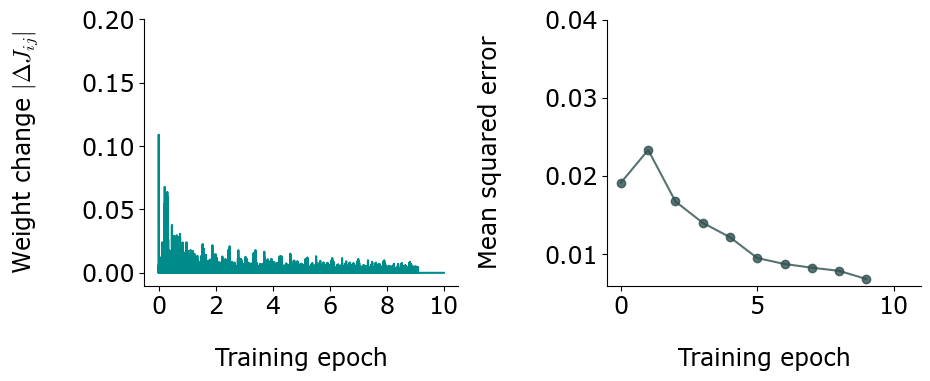

In [35]:
# Weight change and error over learning

rcParams['axes.labelsize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 4), dpi=100)

delta_xaxis = np.linspace(0, len(deltas_all[0]), int((n_tot+1)/2))

ax1.plot(deltas_all[0], color=main_color)
ax1.set_ylabel(r'Weight change $| \Delta J_{ij} |$', rotation=90, labelpad=30)
ax1.set_xlabel('Training epoch')
ax1.set_ylim(-0.01, 0.2)
ax1.set_xticks(delta_xaxis)
ax1.set_xticklabels(np.arange(0, n_tot, 2))
# for epoch in range(n_tot):
#     ax1.axvline(iterations*epoch, color='grey', lw=3, alpha=0.1)

ax2.plot(mses[:-(n_free)], marker='o', color=main_color_dark, alpha=0.8)
ax2.set_ylabel(r'Mean squared error', labelpad=30)
ax2.set_xlabel('Training epoch')
ax2.set_xlim(-0.5, n_tot)
ax2.set_ylim(None, 0.04)
sns.despine(ax=ax1, top=True, right=True)
sns.despine(ax=ax2, top=True, right=True)
fig.tight_layout()
plt.savefig('%s/weight_change.png'%folder, dpi=200)
plt.show()

### Trained connectivity matrix 

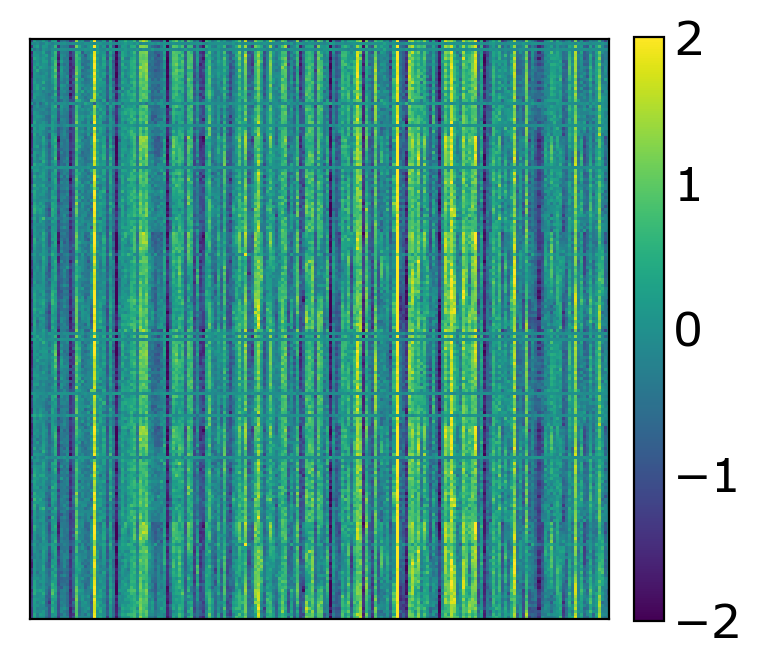

In [36]:
# Visualise matrix as heatmap

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

J_masked = np.ma.masked_where(J==0, J)

scale_limit = 2
im = plt.imshow(J, cmap='viridis', vmin=-scale_limit, vmax=scale_limit)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(size=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('%s/trained_matrix.png'%folder, dpi=200)
plt.show()

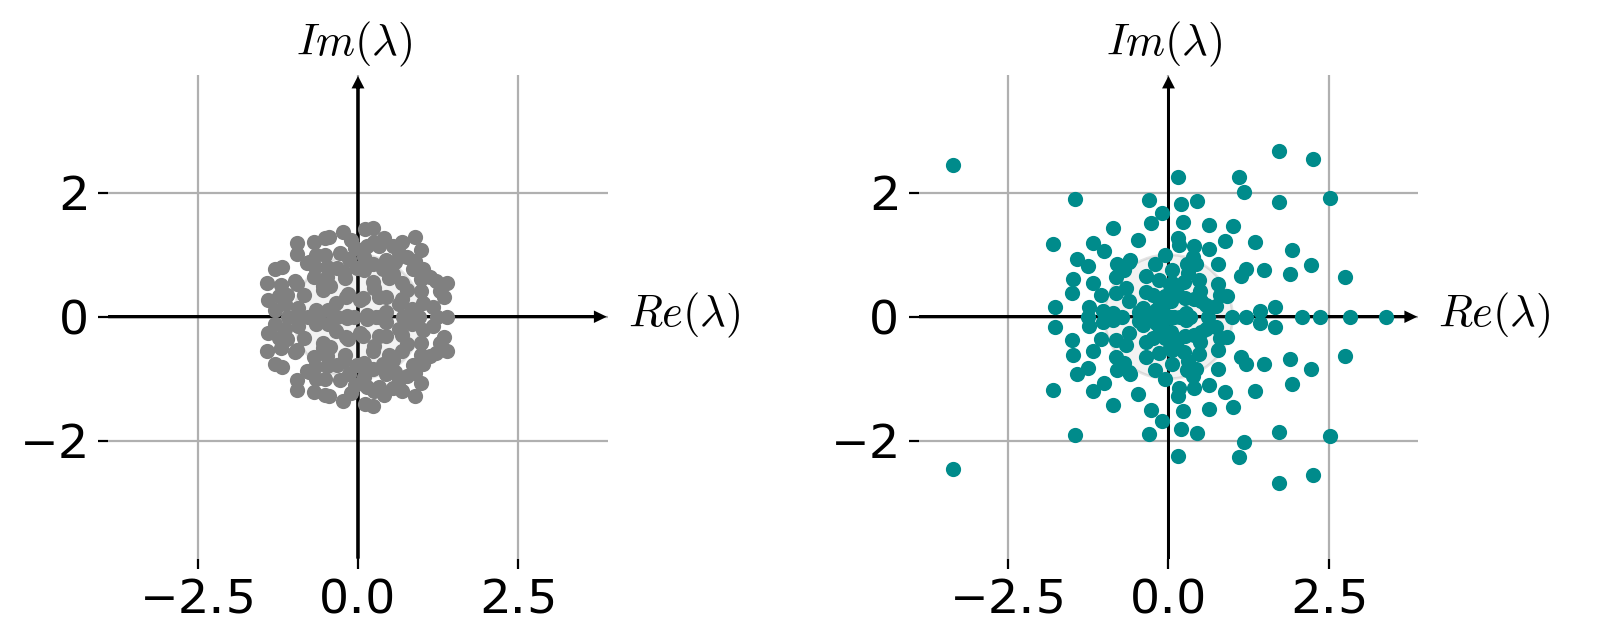

In [37]:
# Eigenspectrum of connectivity matrix

eigvals_J, eigvecs_J = np.linalg.eig(J) 
eigvals_J0, eigvecs_J0 = np.linalg.eig(J0) 

w = 3.9

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.3, 3.4), dpi=200)

for ax in (ax1, ax2):
    ax.grid()
    ax.text(-0.25 * w, 1.08 * w, r'$Im(\lambda)$', fontsize=16)
    ax.text(1.08 * w,  -0.04 * w, r'$Re(\lambda)$    ', fontsize=16)
    ax.set_xlim(-w, w)
    ax.set_ylim(-w, w)
    ax.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    ax.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    circle = plt.Circle((0,0), 1, facecolor='grey', alpha=0.1, fill=True, edgecolor='k')
    ax.add_artist(circle)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
    ax.set_axisbelow(True)
    
for eigval in eigvals_J0:
    ax1.scatter(eigval.real, eigval.imag, color='grey', s=20, zorder=3)

for eigval in eigvals_J:
    ax2.scatter(eigval.real, eigval.imag, color=main_color, s=20, zorder=3)

plt.tight_layout()
plt.savefig('%s/eigenvalues_J.png'%folder, dpi=200)
plt.show()

In [61]:
# Plot eigenvalue change over learning 

fig, axs = plt.subplots(1, len(J_evolution)-1, figsize=(18, 3.1), dpi=200)

w = 2.9

alphas = np.linspace(0, 1, len(axs))[::-1] 

for idx, ax in enumerate(axs):
    ax.grid()
    ax.set_xlim(-w, w)
    ax.set_ylim(-w, w)
    ax.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    ax.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
    circle = plt.Circle((0,0), 1, facecolor='grey', alpha=0.1, fill=True, edgecolor='k')
    ax.add_artist(circle)
    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
    ax.set_axisbelow(True)
    ax.set_title('Epoch %d' % int(save_J_every*idx))

    eigvals, eigvecs = np.linalg.eig(J_evolution[idx]) 

    for i in range(len(eigvals)):
        x = eigvals[i].real
        y = eigvals[i].imag
        ax.scatter(x, y, color=main_color, s=20, zorder=3)
        ax.scatter(x, y, color='grey', alpha = alphas[idx], s=20, zorder=3)
    
plt.tight_layout()
# plt.savefig('positive_sigmoid_delay/eigenvalues_evolution_J.png', dpi=200)
plt.show()


KeyboardInterrupt: 

### Autonomous dynamics

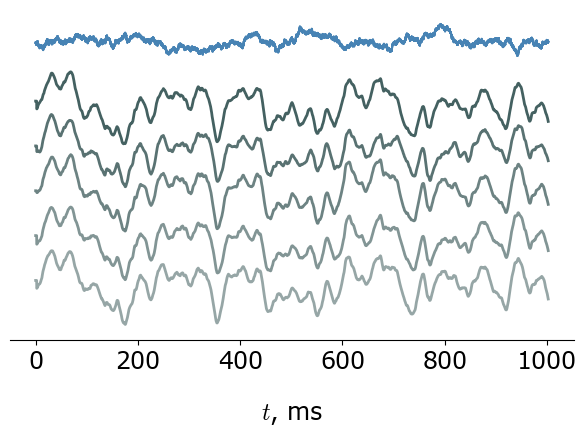

In [112]:
# Run network autonomously 

noise_trial_new = get_noise(N, 1, tau_trial, amp_trial, 0.0)
noise_baseline_graded_new = get_noise_amp_graded(N, 1, taus_baseline, amps_baseline, 0) 


x1a = np.zeros((N, iterations))
zs_noise = np.zeros((N, iterations-1)) 

for t in range(D, iterations-1):
    x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + noise_trial_new[0][:, t] + noise_baseline_graded_new[0][:, t]*1.3) * dt / tau
    zs_noise[:, t] = J.dot(nonlinearity(x1a[:, t+1]))
                    
# Plot currents over timecourse of target
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)

for i in range(10, 15): 
    ax.plot(rescale_ms[:-1], zs_noise[i, :max_length-1] + i , color=main_color_dark, alpha=((i/10 - 1)+0.5), linewidth=2)
    ax.plot(rescale_ms, noise_baseline_graded_new[0][-1]+15.3, color='steelblue', alpha=.6)
#     ax.plot(rescale_ms, noise_trial_new[0][-1]+15.3, color='steelblue', alpha=.3)
    
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('$t$, ms', labelpad=20)
sns.despine(ax=ax, top=True, right=True, left=True)
fig.tight_layout()
plt.savefig('%s/novel_noise.png'%folder, dpi=200)
plt.show()

In [26]:
# Gif of novel noise response

signal_to_plot = zs_noise 

frames = []
scale_limit = 0.8

fig = plt.figure()
plt.axis('off')
for i in np.arange(0, max_length, 50):
    lfp_at_timepoint = signal_to_plot[:, i]
    lfp_reshape = np.reshape(lfp_at_timepoint[reshape_unravelled], (10, 10))
    lfp_reshape_masked = np.ma.masked_where(reshape==-2, lfp_reshape)
    image = plt.imshow(lfp_reshape_masked, cmap='gist_heat', animated=True, vmin=-scale_limit, vmax=scale_limit)
    frames.append([image])
plt.close()

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True, repeat_delay=1000) 

HTML(ani.to_html5_video())



In [27]:
ani.save('%s/zs_noise_gif.mp4' %folder , writer=writer) 

In [28]:
# Gif of phase of novel noise response

hilbert_signal = signal.hilbert(zs_noise, axis=1)
phase=np.angle(hilbert_signal)
amplitude=np.abs(hilbert_signal)

signal_to_plot = phase
frames = []
scale_limit = np.pi

fig = plt.figure()
plt.axis('off')
for i in np.arange(0, max_length, 50):
    lfp_at_timepoint = signal_to_plot[:, i]
    lfp_reshape = np.reshape(lfp_at_timepoint[reshape_unravelled], (10, 10))
    lfp_reshape_masked = np.ma.masked_where(reshape==-2, lfp_reshape)
    image = plt.imshow(lfp_reshape_masked, cmap='bone', animated=True, vmin=-scale_limit, vmax=scale_limit)
    frames.append([image])
plt.close()

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True, repeat_delay=1000) 

HTML(ani.to_html5_video())

In [29]:
ani.save('%s/targets_phase.mp4' %folder , writer=writer) 

### Fourier analysis of new noise response

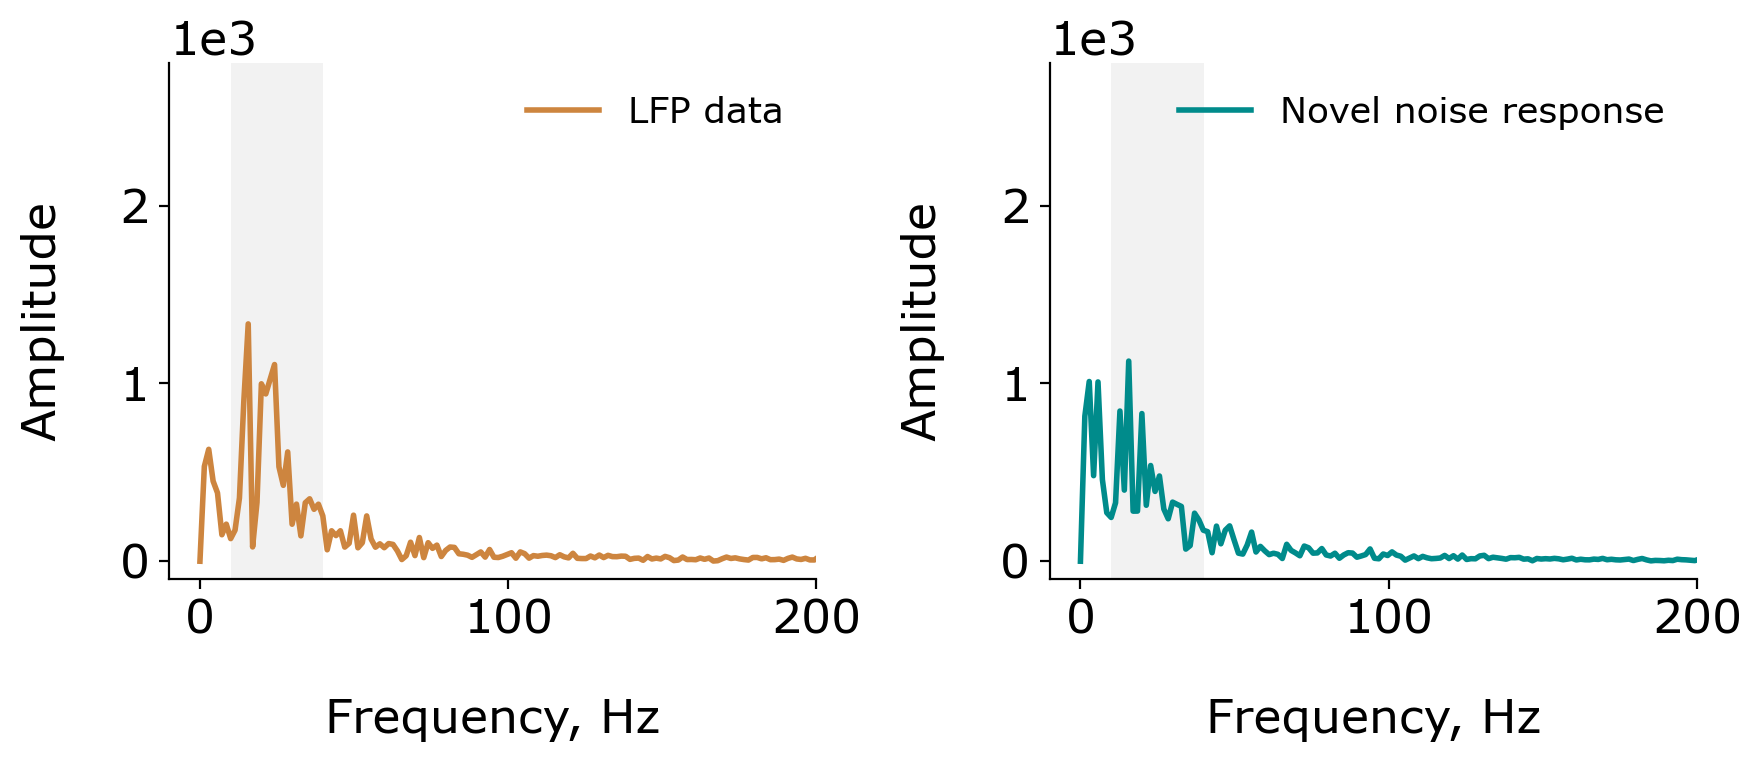

In [43]:
# Fourier analysis of new noise response

trained_response_all = []
noise_response_all = []

for i in range(n_targets):
#     if i < n_targets:
    trained_response = targets_duplicated[0][i] - targets_duplicated[0][i].mean()
    yf_trained = rfft(trained_response)
    trained_response_all.append(yf_trained)
    noise_response = zs_noise[i] - zs_noise[i].mean()
    
    yf_noise = rfft(noise_response)
    noise_response_all.append(yf_noise)

trained_response_avg = np.mean(trained_response_all, axis=0)
noise_response_avg = np.mean(noise_response_all, axis=0)

duration_s = float(rescale_ms[-1].magnitude) / 1000  # duration in seconds
sample_rate = len(noise_response)/duration_s  # number of samples per second

xf_noise = rfftfreq(noise_response.size, 1/sample_rate)
xf_trained = rfftfreq(trained_response.size, 1/sample_rate)


rcParams['axes.labelsize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

ax1.plot(xf_trained, np.abs(trained_response_avg), color='peru', lw=2, label='LFP data')
ax2.plot(xf_noise, np.abs(noise_response_avg), color=main_color, lw=2, label='Novel noise response')

for ax in (ax1, ax2):
    ax.set_xlim(-10, 200)
    ax.set_ylim(-100, 2.8*10**3)
    ax.set_xlabel('Frequency, Hz', labelpad=20)
    ax.set_ylabel('Amplitude', labelpad=20)
    ax.axvspan(10, 40, color='grey', ec=None, alpha=0.1)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=True, useMathText=None)
    ax.legend(frameon=False, loc=0, fontsize=13)
    sns.despine(ax=ax, top=True, right=True)
    
fig.tight_layout()
plt.savefig('%s/fourier_spectrum.png'%folder, dpi=200)
plt.show()

### Autocorrelation function of noise response

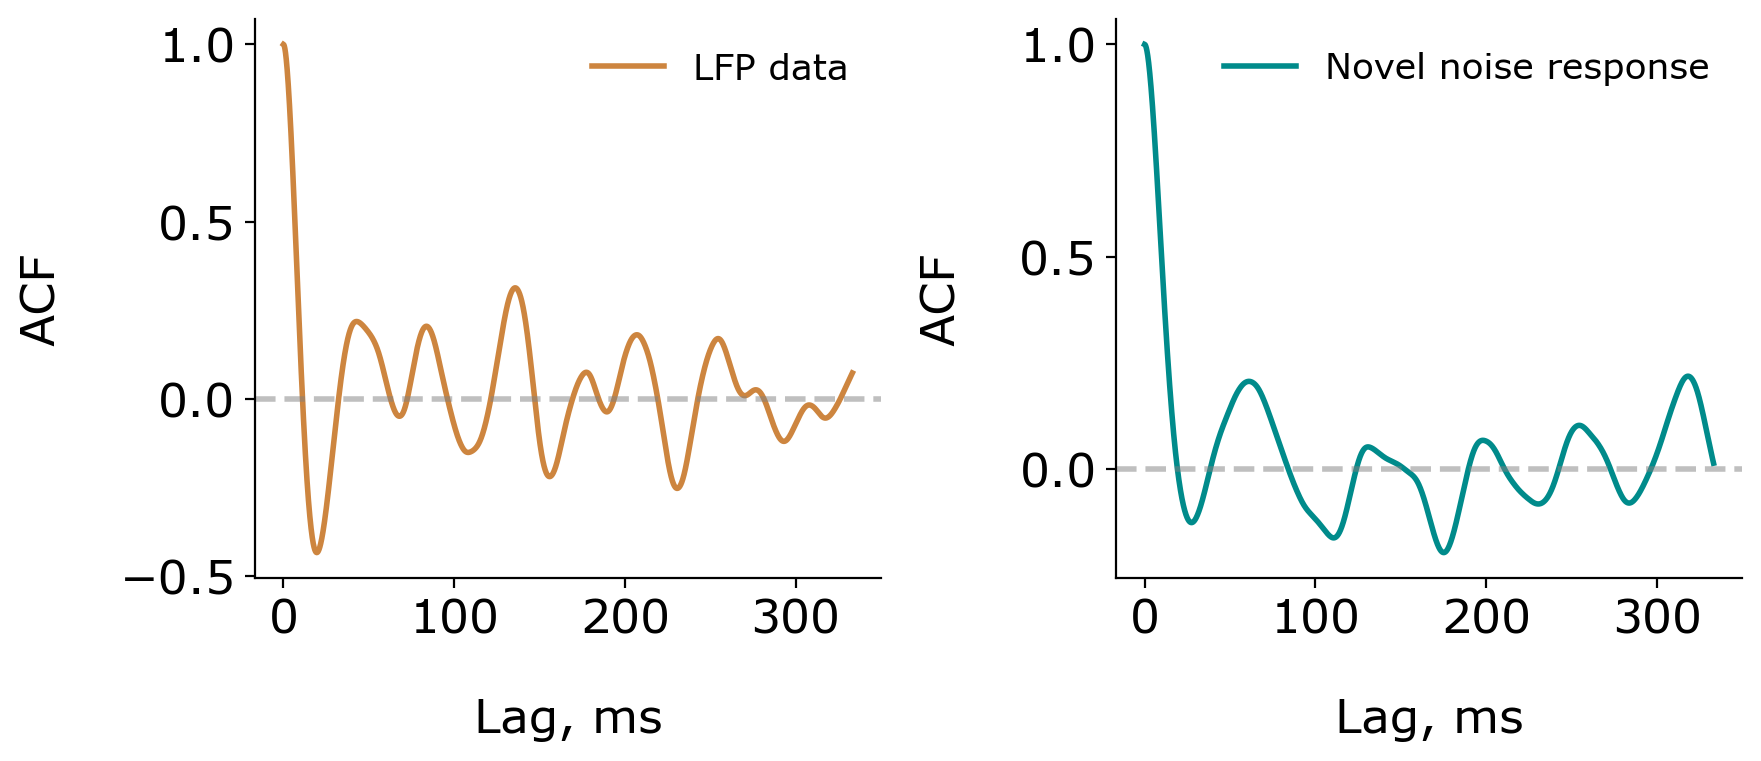

In [44]:
# Autocorrelation of new noise response

lags=range(10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

iterations_to_ms = float(rescale_ms[-1].magnitude) / max_length

ax1.plot(np.arange(0, len(lags))*iterations_to_ms, autocorr(targets_duplicated[0][0], lags), lw=2, color='peru', label='LFP data')
ax2.plot(np.arange(0, len(lags))*iterations_to_ms, autocorr(zs_noise[8], lags), lw=2, color=main_color, label='Novel noise response')

for ax in (ax1, ax2):
    ax.axhline(0, color='grey', alpha=0.5, lw=2, ls='--')
    ax.set_xlabel('Lag, ms', labelpad=20) # convert to ms
    ax.set_ylabel('ACF', labelpad=20)

    ax.legend(frameon=False, loc=0, fontsize=13)
    sns.despine(ax=ax, top=True, right=True)
    
fig.tight_layout()
plt.savefig('%s/autocorrelation.png' %folder, dpi=200)
plt.show()


### Visualise 'excitatory' and 'inhibitory' units

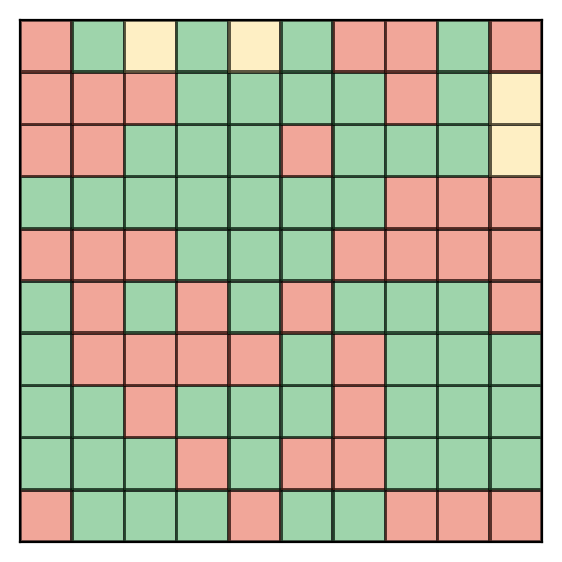

In [78]:
pos_idx = np.mean(J, axis=0)>=0
neg_idx = np.mean(J, axis=0)<0

series = np.array(range(0, len(pos_idx)))

excitatory_neurons = series[pos_idx]
inhibitory_neurons = series[neg_idx]

# Define electrode array grid 

def get_arraygrid(blackrock_elid_list, excitatory=[], inhibitory=[], rej_el=[]):
    array_grid = np.zeros((10, 10))
    for m in range(10):
        for n in range(10):
            idx = (9 - m) * 10 + n
            bl_id = bl_id_corrected[idx]
            if bl_id in excitatory:
                array_grid[m, n] = 0.7
            elif bl_id in inhibitory:
                array_grid[m, n] = -0.7
            else:
                array_grid[m, n] = -0.2
    return np.ma.array(array_grid, mask=np.isnan(array_grid))

# Visualise electrode placement 

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

arraygrid = get_arraygrid(blackrock_elid_list, excitatory_neurons, inhibitory_neurons, rej_el=[[i] for i in remove_idxs])
cmap = plt.cm.RdYlGn
ax.pcolormesh(np.flipud(arraygrid), vmin=-1, vmax=1, lw=1, cmap=cmap, alpha=0.5, edgecolors='k', shading='auto')

ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.show()



### Response to pulse input

<ipython-input-48-2143eb593588>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '-200', '0', '200', '400'])


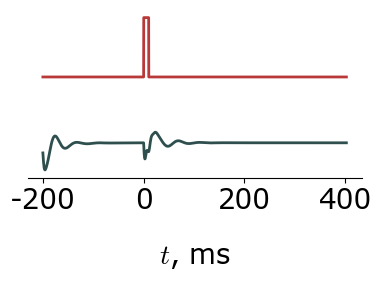

In [48]:
# Run network autonomously with input pulse

rcParams['axes.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

amp_pulse = 1
duration_pulse = 300
start_pulse = int(ms_to_tau(200))
stop_pulse = int(start_pulse + duration_pulse)
pulse_input = np.zeros((N, iterations))

chosen_unit = 1

pulse_input[chosen_unit, start_pulse:stop_pulse] = np.tile(1, duration_pulse) * 4

x1a = np.zeros((N, iterations))
zsa = np.zeros((N, iterations-1)) 

for t in range(iterations-1):
    x1a[:, t+1] = x1a[:, t] + (-x1a[:, t] + J.dot(nonlinearity(x1a[:, t-D])) + pulse_input[:, t]) * dt / tau
    zsa[:, t] = J.dot(nonlinearity(x1a[:, t+1]))
                    
# Plot currents over timecourse of target
fig, ax = plt.subplots(figsize=(4, 3), dpi=100)

minus = 3000

ax.plot(rescale_ms[:-minus-1], zsa[0, :-minus], color=main_color_dark, alpha=1, linewidth=2)

ax.plot(rescale_ms[:-minus], pulse_input[chosen_unit, :-minus]/4 + 1.2, color='firebrick', lw=2, alpha=0.9)

ax.set_xticklabels(['0', '-200', '0', '200', '400'])

# ax.axvspan(tau_to_ms(start_pulse), tau_to_ms(stop_pulse), color='k', alpha=0.1, ec=None)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel(r'$t$, ms', labelpad=20)
sns.despine(ax=ax, top=True, right=True, left=True)
fig.tight_layout()
plt.show()

In [124]:
# Gif of response to pulse input 

signal_to_plot = zsa 

frames = []
scale_limit = 0.8

fig = plt.figure()
plt.axis('off')
for i in np.arange(3000, int(max_length/2)-500, 15):
    lfp_at_timepoint = signal_to_plot[:, i]
    lfp_reshape = np.reshape(lfp_at_timepoint[reshape_unravelled], (10, 10))
    lfp_reshape_masked = np.ma.masked_where(reshape==-2, lfp_reshape)
    image = plt.imshow(lfp_reshape_masked, cmap='gist_heat', animated=True, vmin=-scale_limit, vmax=scale_limit)
    frames.append([image])
plt.close()

ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True, repeat_delay=1000) 

HTML(ani.to_html5_video())


In [125]:
ani.save('%s/zs_tms.mp4' %folder , writer=writer) 

### Linear stability analysis

In [49]:
def system(x, J, D):
    return (-x + J.dot(nonlinearity(x-D/tau)))/tau  # necessary to put D in?

def q(x, J):
    return 1/2 * np.linalg.norm(system(x, J))**2

# Fixed point found by running the dynamics
fixed_point = zsa[:, -1]

# Define Jacobian
jacobian_sys = nd.Jacobian(system)
jacobian_fp = jacobian_sys(fixed_point, J, D)

# Plot eigenvalues of Jacobian at fixed point
eigvals_jacobian, eigvecs_jacobian = np.linalg.eig(jacobian_fp)  # units of eigvals = 1/t ?

# Sort eigenvalues in descending order
idx = eigvals_jacobian.argsort()[::-1]   
eigvals_jacobian = eigvals_jacobian[idx]
eigvecs_jacobian = eigvecs_jacobian[:,idx]

In [50]:
# Frequency of oscillations

print('Frequency: ', eigval_to_hz(max(eigvals_jacobian.imag)))
print('Max real:', max(eigvals_jacobian.real), '  Index', np.argmax(eigvals_jacobian.real))
print('Min real:', min(eigvals_jacobian.real), '  Index', np.argmin(eigvals_jacobian.real))
print('Max imag:', max(eigvals_jacobian.imag), '  Index', np.argmax(eigvals_jacobian.imag))


Frequency:  36.43221077898951
Max real: -0.0017560807273981514   Index 0
Min real: -0.01913479182615319   Index 286
Max imag: 0.007629982308634013   Index 114


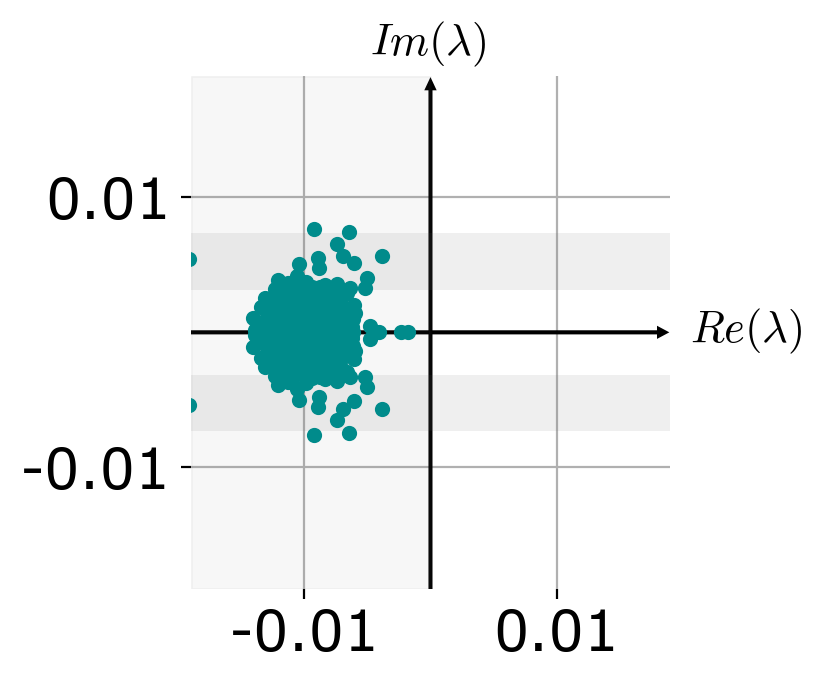

In [51]:
w = 0.019
fig, ax = plt.subplots(figsize=(4.3, 3.6), dpi=200)

plt.axis('on')
plt.grid()
plt.text(-0.25 * w, 1.08 * w, r'$Im(\lambda)$', fontsize=16)
plt.text(1.08 * w,  -0.04 * w, r'$Re(\lambda)$', fontsize=16)
plt.xlim(-w, w)
plt.ylim(-w, w)
plt.arrow(0, -w, 0, 1.95 * w, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)
plt.arrow(-w, 0, 1.95 * w, 0, width=0.0001, head_width=w / 30, head_length=w / 30, color='black', zorder=1)

for i in range(len(eigvals_jacobian)):
    x = eigvals_jacobian[i].real
    y = eigvals_jacobian[i].imag
    plt.scatter(x, y, color='darkcyan', s=20, zorder=3)

circle = plt.Circle((0,0), 1, color='k', alpha=0.2, fill=False)
plt.gcf().gca().add_artist(circle)

ax.axvspan(-w, 0, alpha=0.05, color='dimgrey')
ax.axhspan(hz_to_eigval(15), hz_to_eigval(35), alpha=0.1, color='dimgrey', ec=None)
ax.axhspan(hz_to_eigval(-15), hz_to_eigval(-35), alpha=0.1, color='dimgrey', ec=None)

ax.set_xticks([-0.01, 0.01])
ax.set_xticklabels([-0.01, 0.01])
ax.set_yticks([-0.01, 0.01])
ax.set_yticklabels([-0.01, 0.01])

sns.despine(top=True, right=True, left=True, bottom=True)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('%s/eigenvalues_jacobian.png' %folder, dpi=230)
plt.show()

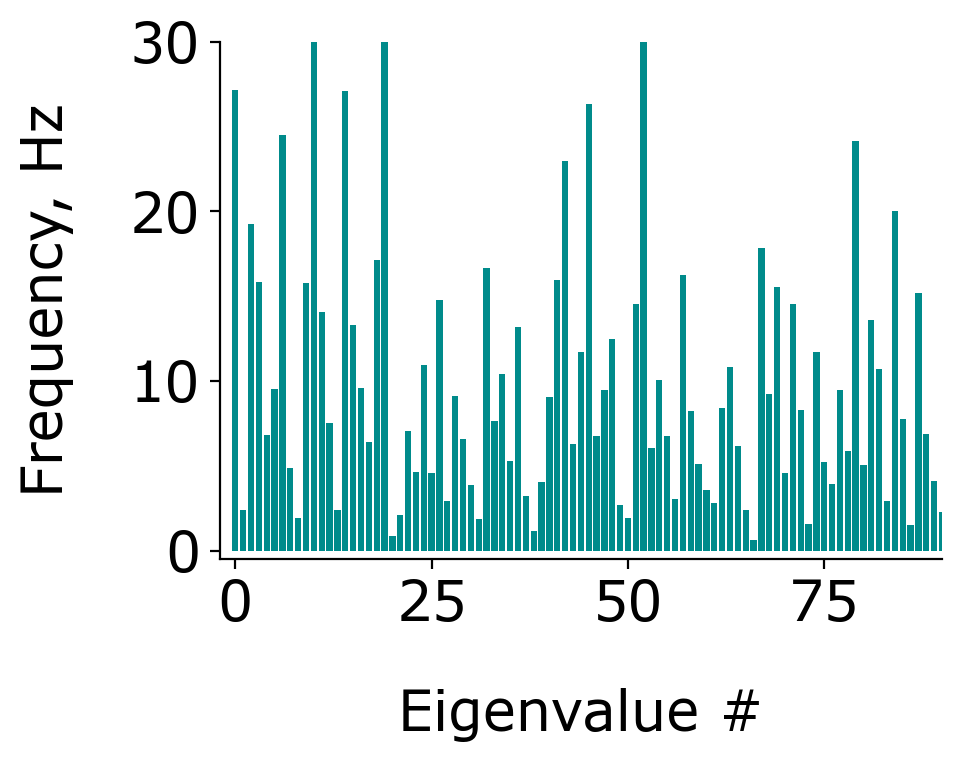

In [53]:
# Plot frequencies of each eigenvalue 

frequencies = [eigval_to_hz(x) for x in eigvals_jacobian.imag]

freq_unique = np.delete(np.array(frequencies), np.array(frequencies)<=0)
eigvals_real_unique = eigvals_jacobian.real[::2]

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

ax.bar(range(len(freq_unique)), freq_unique, color=main_color)
ax.add_patch(patches.Rectangle((-1, -0.5), 100, 0.5, facecolor='white', fill=True))
ax.set_xlabel('Eigenvalue #', labelpad=20)
ax.set_ylim(-.5, 30)
ax.set_ylabel('Frequency, Hz', labelpad=20)
ax.set_xlim(-2, 45*2)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.savefig('%s/frequencies.png' %folder, dpi=200)
plt.show()


### Weight decay analysis

In [ ]:
distances = np.arange(0, 10, 1)

tau_trial = 10
amp_trial = 0.00
tau_baseline = ms_to_tau(13)
amp_baseline = 0.00
taus_baseline = np.linspace(ms_to_tau(5), ms_to_tau(15), N)
amps_baseline = np.linspace(0.00, 0.04, N)

n_train = 10
dt_weight_update = 10
D = 0

dist_means_J_all = []
dist_stds_J_all = []
dist_means_J0_all = []
dist_stds_J0_all = []
pos_means_J_all = []
pos_stds_J_all = []
neg_means_J_all = []
neg_stds_J_all = []

for repeat in range(3):
    
    J0, J = training(D, dt_weight_update, n_train, tau_trial, tau_baseline, amp_trial, amp_baseline, taus_baseline, amps_baseline)
    dist_means_J, dist_stds_J = weights_vs_distance(J, distances)
    dist_means_J0, dist_stds_J0 = weights_vs_distance(J0, distances)
    pos_means_J, pos_stds_J, neg_means_J, neg_stds_J = weights_vs_distance_pos_neg(J, distances)
    
    dist_means_J_all.append(dist_means_J)
    dist_stds_J_all.append(dist_stds_J)
    dist_means_J0_all.append(dist_means_J0)
    dist_stds_J0_all.append(dist_stds_J0)
    
    pos_means_J_all.append(pos_means_J)
    pos_stds_J_all.append(pos_stds_J)
    neg_means_J_all.append(neg_means_J)
    neg_stds_J_all.append(neg_stds_J)
    
dist_means_J_avg = np.mean(dist_means_J_all, axis=0)
dist_stds_J_avg = np.mean(dist_stds_J_all, axis=0)
dist_means_J0_avg = np.mean(dist_means_J0_all, axis=0)
dist_stds_J0_avg = np.mean(dist_stds_J0_all, axis=0)
pos_means_J_avg = np.mean(pos_means_J_all, axis=0)
pos_stds_J_avg = np.mean(pos_stds_J_all, axis=0)
neg_means_J_avg = np.mean(neg_means_J_all, axis=0)
neg_stds_J_avg = np.mean(neg_stds_J_all, axis=0)

In [ ]:
# Mean weight decay across all weights

fig, ax = plt.subplots(figsize=(6.3, 5), dpi=200)

def weight_function(distances, a, lambd):
    return [a * np.exp(-lambd * dist) for dist in distances]

distances = np.arange(0, 10, 1) * 0.4
dists_finescale = np.arange(0, 9.1, 0.1) * 0.4

ax.plot(distances, dist_means_J0_avg, color=main_color_dark, lw=2, alpha=.5, label=r'$J_0$')
ax.plot(distances, dist_means_J_avg, color=main_color, lw=2, label=r'$J$')
ax.plot(dists_finescale, weight_function(dists_finescale, 0.25, 2), color='k', alpha=0.7, ls='--', lw=2, label=r'$C(d)$')

plt.fill_between(distances, np.array(dist_means_J0_avg)-dist_stds_J0_avg, np.array(dist_means_J0_avg)+dist_stds_J0_avg, alpha=.1, color=main_color_dark)
plt.fill_between(distances, np.array(dist_means_J_avg)-dist_stds_J_avg, np.array(dist_means_J_avg)+dist_stds_J_avg, alpha=.1, color='lightseagreen')

ax.set_xlabel('Distance on array, mm')
ax.set_ylabel(r'$\langle \; J_{ij} \; \rangle$', fontsize=18, labelpad=30, rotation=0)
ax.set_title(r'$\tau_{trial} = %.f \; ms$    $a_{trial}=%.2f$     $\tau_{baseline} = %s \; ms$    $a_{baseline}=%s$' % (tau_to_ms(tau_trial), amp_trial, '5-15', '0-0.04'), pad=20, fontsize=13)

ax.set_ylim(-1.2, 1.2)
ax.legend(loc=1, bbox_to_anchor=[1.4, 0.65], fontsize=15)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.savefig('%s/weight_decay.png' %folder, dpi=200)
plt.show()

In [ ]:
# Mean weight decay for positive and negative weights

fig, ax = plt.subplots(figsize=(6.2, 5), dpi=200)

distances = np.arange(0, 10, 1) * 0.4

ax.plot(distances, dist_means_J0_avg, color=main_color_dark, lw=2, alpha=.5, label=r'$J_0$')

ax.plot(distances, pos_means_J_avg, color=positive_color, lw=2, label=r'$J^{+}$')
ax.plot(distances, neg_means_J_avg, color=negative_color, lw=2, label=r'$J^{-}$')

plt.fill_between(distances, np.array(dist_means_J0_avg)-dist_stds_J0_avg, np.array(dist_means_J0_avg)+dist_stds_J0_avg, alpha=.1, color=main_color_dark)

plt.fill_between(distances, np.array(pos_means_J_avg)-pos_stds_J_avg, np.array(pos_means_J_avg)+pos_stds_J_avg, alpha=.1, color=positive_color)
plt.fill_between(distances, np.array(neg_means_J_avg)-neg_stds_J_avg, np.array(neg_means_J_avg)+neg_stds_J_avg, alpha=.1, color=negative_color)

ax.set_xlabel('Distance on array, mm')
ax.set_ylabel(r'$\langle \; J_{ij} \; \rangle$', fontsize=18, labelpad=30, rotation=0)
ax.set_title(r'$\tau_{trial} = %.f \; ms$    $a_{trial}=%.2f$     $\tau_{baseline} = %s \; ms$    $a_{baseline}=%s$' % (tau_to_ms(tau_trial), amp_trial, '5-15', '0-0.04'), pad=20, fontsize=13)

ax.set_ylim(-1.2, 1.2)
ax.legend(loc=1, bbox_to_anchor=[1.3, 0.7], fontsize=15)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
plt.savefig('%s/weight_decay_pos_neg.png' %folder, dpi=200)
plt.show()

### Weights visualised on electrode grid

In [ ]:
selected_unit = 20

outgoing_weights = J[:, selected_unit]
incoming_weights = J[selected_unit, :]
outgoing_weights_reshape = np.reshape(outgoing_weights[reshape_unravelled], (10, 10))
outgoing_weights_reshape_masked = np.ma.masked_where(reshape==-2, outgoing_weights_reshape)
outgoing_weights_reshape_selected = np.ma.masked_where(reshape!=selected_unit, outgoing_weights_reshape)

fig, ax = plt.subplots(figsize=(4.2, 4), dpi=100)
scale_limit = 2
im = plt.imshow(outgoing_weights_reshape_masked, cmap='viridis', vmin=-scale_limit, vmax=scale_limit)
im2 = plt.imshow(outgoing_weights_reshape_selected, cmap='Set1')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(size=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Electrode ID: %s' %selected_unit, pad=20)
plt.show()


In [ ]:
filenames = []

for ind, unit in enumerate(reshape_unravelled):
    
    if (unit != -2 and unit != 95):
        
        filenames.append('weights_visualised/position%s.jpg' %ind)
        
#         outgoing_weights = (J[:, unit] + J[:, unit+97]) / 2
#         incoming_weights = (J[unit, :] + J[unit+97, :]) / 2

        unit = unit + 97
        outgoing_weights = J[:, unit]
        incoming_weights = J[unit, :]

        outgoing_weights_reshape = np.reshape(outgoing_weights[reshape_unravelled], (10, 10))
        outgoing_weights_reshape_masked = np.ma.masked_where(reshape==-2, outgoing_weights_reshape)
        outgoing_weights_reshape_selected = np.ma.masked_where(reshape!=unit-97, outgoing_weights_reshape)

        fig, ax = plt.subplots(figsize=(4.2, 4), dpi=100)

#         if outgoing_weights.max() >= 2 or outgoing_weights.min() <= -2:
#             scale_limit = 3
        
        scale_limit = 2

        im = plt.imshow(outgoing_weights_reshape_masked, cmap='viridis', vmin=-scale_limit, vmax=scale_limit)
        im2 = plt.imshow(outgoing_weights_reshape_selected, cmap='Set1')
        cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(size=0)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Electrode ID: %s $_2$' %int(unit-97), pad=20)
        plt.savefig('weights_visualised/position%s.jpg' %ind, dpi=200)
        plt.close(fig)

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('%s/weights_visualised.gif' %folder, images, duration=0.4)



